# Compte Rendu TP3 - Opinion Mining "TWITTER"

**1. Définition de l'objectif :**

L’intérêt principal est de pouvoir récolter du contenu sur les sites web, dans le but d’aider l’entreprise à augmenter son chiffre d’affaire, à se démarquer sur son marché et à faire face aux incertitudes.
Pour en faire, nous allons se concentrer sur les avis des consommateurs afin d'y extraire les forces et les faiblesses et analyser la réputation et l'image de l'entreprise à travers une analyse sentimentale et d'opinions. Les avis négatifs seront par la suite analysés pour en déduire les causes d'insatisfaction et améliorer la production.




**2. Les méthodes utilisées :**

In [0]:
from pprint import pprint
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
from pywaffle import Waffle
from wordcloud import WordCloud
import goslate
import urllib
import urllib.request as urllib2
from collections import Counter
import spacy

import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaMulticore
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
from sklearn.model_selection import train_test_split
import numpy
import nltk
import re
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords


In [78]:
df= pd.read_csv("new_twitter.csv",sep=",")
df.head()

,tweet_id,text,created_at,source,tokens
0,1210485972514885634,♻️ Une nouvelle étape pour McDo 🇫🇷 dans la réd...,2019-12-27 09:02:00,TweetDeck,"['nouvel', 'étap', 'mcdo', 'réduct', 'empreint..."
1,1210111001678536704,J'ai commencé comme :\n✔️Équipier\n✔️Formateur...,2019-12-26 08:12:00,TweetDeck,"['commenc', 'comm', 'zon', 'manag', 'tout', 'a..."
2,1209060286734487552,Très heureux de continuer à construire notre p...,2019-12-23 10:36:50,Twitter Web App,"['tres', 'heureux', 'continu', 'construir', 'p..."
3,1207940449245134848,"Mélanie, resp. de #formation chez McDo 🇫🇷\n🎬 U...",2019-12-20 08:27:00,TweetDeck,"['mélan', 'resp', 'format', 'chez', 'mcdo', 'j..."
4,1206515505655357440,Emballages en plastique à usage unique :\n♻️ U...,2019-12-16 10:04:47,Twitter Web App,"['emballag', 'plastiqu', 'usag', 'uniqu', 'nou..."


Préparation des données au test d'opinions 

In [79]:
Token=df['tokens']
Token[1]

"['commenc', 'comm', 'zon', 'manag', 'tout', 'accompagn', 'http']"

In [80]:
for i in range(len(Token)):
 Token[i] = re.sub("[^\w]", " ",  Token[i]).split()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
nltk.download('punkt')
New_text = []
for i in range(len(Token)):
    New_text.append(" ".join(Token[i]))

df["tokens"]=New_text
df["text"]=df["tokens"].apply(word_tokenize)
All_text = ''.join(text for text in df['tokens'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [83]:
df.head()

,tweet_id,text,created_at,source,tokens
0,1210485972514885634,"[nouvel, étap, mcdo, réduct, empreint, environ...",2019-12-27 09:02:00,TweetDeck,nouvel étap mcdo réduct empreint environnement...
1,1210111001678536704,"[commenc, comm, zon, manag, tout, accompagn, h...",2019-12-26 08:12:00,TweetDeck,commenc comm zon manag tout accompagn http
2,1209060286734487552,"[tres, heureux, continu, construir, partenaria...",2019-12-23 10:36:50,Twitter Web App,tres heureux continu construir partenariat arm...
3,1207940449245134848,"[mélan, resp, format, chez, mcdo, journ, typ, ...",2019-12-20 08:27:00,TweetDeck,mélan resp format chez mcdo journ typ rôl tant...
4,1206515505655357440,"[emballag, plastiqu, usag, uniqu, nouveau, gob...",2019-12-16 10:04:47,Twitter Web App,emballag plastiqu usag uniqu nouveau gobelet c...


In [0]:
nltk.download('stopwords')
all_words=freq_words(df['tokens'], 20)

In [0]:
stop_words = set(stopwords.words('french') + ['AT_USER','URL','rt','http','là','ça','quoi','si','cet','tous','plus','chez'])

In [0]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new


In [0]:
removed = remove_stopwords(all_words)


In [0]:
words = re.sub("[^\w]", " ", removed).split()


# Les Graphes : 

-	Les graphes comme pie chart, bar plot pour connaitre les mots les plus fréquents dans les tweets et cela peut nous donner une idée générale sur le sujet dominant et ce que pensent les clients de « MacdoFrance », Ils nous ont indiqué la source des tweets (Web, Mobile .. ) et avec ça on a pu déterminer la tranche d’âge qui met plus de tweet dans ce sujet. 

In [0]:
# function to plot most frequent terms
def freq_word(x, terms = 20):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

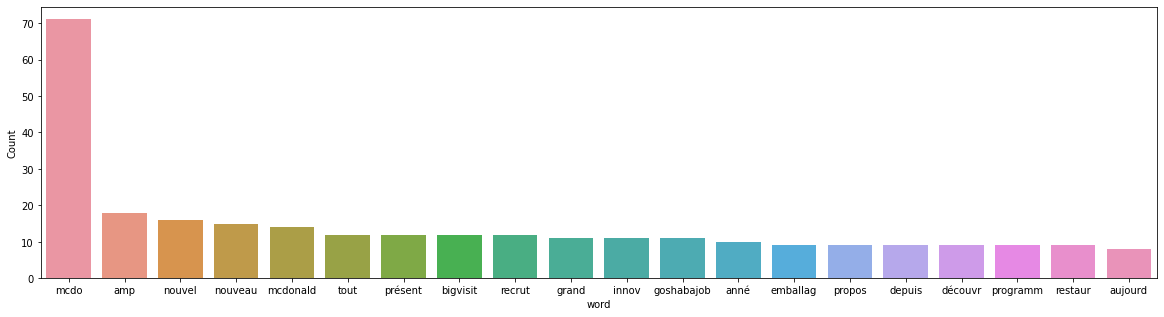

In [94]:
all=freq_word(words, 20)

# Intérprétation: 
-	Après l’extraction des 20 mots les plus fréquents dans les tweets on a pu remarquer la présence des mots nouveau, emballage,découvrir, innovation et cela explique par le fait que « MacdoFrance » ont changé l’emballage de leurs produit après le Covid-19 et cela n’a pas plu au clients 

Définition des colonnes pour l'analyse sentimentale

In [95]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [96]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["sentiments"] =df["tokens"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)
df.head()

,tweet_id,text,created_at,source,tokens,neg,neu,pos,compound
0,1210485972514885634,"[nouvel, étap, mcdo, réduct, empreint, environ...",2019-12-27 09:02:00,TweetDeck,nouvel étap mcdo réduct empreint environnement...,0.0,1.0,0.0,0.000
1,1210111001678536704,"[commenc, comm, zon, manag, tout, accompagn, h...",2019-12-26 08:12:00,TweetDeck,commenc comm zon manag tout accompagn http,0.2,0.8,0.0,-0.128
2,1209060286734487552,"[tres, heureux, continu, construir, partenaria...",2019-12-23 10:36:50,Twitter Web App,tres heureux continu construir partenariat arm...,0.0,1.0,0.0,0.000
3,1207940449245134848,"[mélan, resp, format, chez, mcdo, journ, typ, ...",2019-12-20 08:27:00,TweetDeck,mélan resp format chez mcdo journ typ rôl tant...,0.0,1.0,0.0,0.000
4,1206515505655357440,"[emballag, plastiqu, usag, uniqu, nouveau, gob...",2019-12-16 10:04:47,Twitter Web App,emballag plastiqu usag uniqu nouveau gobelet c...,0.0,1.0,0.0,0.000


In [0]:
df.to_csv('data_processed.csv',index=False,header=["tweet_id",	"text","created_at","source","tokens","neg","neu","pos","compound"])

In [0]:
from textblob import TextBlob
import matplotlib.pyplot as plt
df.to_csv ('data_processed.csv')

In [0]:

# Creating an empty Dataframe with column names only
pos = pd.DataFrame(columns=['text',	'created_at',	'source',	'tokens',	'neg',	'neu',	'pos',	'compound'])
neg = pd.DataFrame(columns=['text',	'created_at',	'source',	'tokens',	'neg',	'neu',	'pos',	'compound'])

In [0]:
class OpinionAnalysis:

    

    def DownloadData(self):
        
        csvFile = open('data_processed.csv', 'a')

        # Use csv writer
        #csvWriter = csv.writer(csvFile)


        # creating some variables to store info
        polarity = 0
        positive = 0
        wpositive = 0
        spositive = 0
        negative = 0
        wnegative = 0
        snegative = 0
        neutral = 0
        i=0
        tp=0
        pos = pd.DataFrame(columns=['text',	'created_at',	'source',	'tokens',	'neg',	'neu',	'pos',	'compound'])
        
        

        # iterating through tweets fetched
        for tweet in df['tokens']:
            

            #Append to temp so that we can store in csv later. I use encode UTF-8
            #self.tweetText.append(self.cleanTweet(tweet.text).encode('utf-8'))
            # print (tweet.text.translate(non_bmp_map))    #print tweet's text
            analysis = TextBlob(tweet)
            # print(analysis.sentiment)  # print tweet's polarity
            polarity += analysis.sentiment.polarity  # adding up polarities to find the average later

            if (analysis.sentiment.polarity == 0):  # adding reaction of how people are reacting to find average later
                neutral += 1
            elif (analysis.sentiment.polarity > 0 and analysis.sentiment.polarity <= 0.3):
                wpositive += 1
            elif (analysis.sentiment.polarity > 0.3 and analysis.sentiment.polarity <= 0.6):
                positive += 1
                pos=pos.append(df.iloc[i])
                i= i+1
                
            elif (analysis.sentiment.polarity > 0.6 and analysis.sentiment.polarity <= 1):
                spositive += 1
            elif (analysis.sentiment.polarity > -0.3 and analysis.sentiment.polarity <= 0):
                wnegative += 1
            elif (analysis.sentiment.polarity > -0.6 and analysis.sentiment.polarity <= -0.3):
                negative += 1
            elif (analysis.sentiment.polarity > -1 and analysis.sentiment.polarity <= -0.6):
                snegative += 1


        # Write to csv and close csv file
        #csvWriter.writerow(self.tweetText)
        #csvFile.close()
        NoOfTerms=len(df)
        # finding average of how people are reacting
        positive = self.percentage(positive, NoOfTerms)
        wpositive = self.percentage(wpositive, NoOfTerms)
        spositive = self.percentage(spositive, NoOfTerms)
        negative = self.percentage(negative, NoOfTerms)
        wnegative = self.percentage(wnegative, NoOfTerms)
        snegative = self.percentage(snegative, NoOfTerms)
        neutral = self.percentage(neutral, NoOfTerms)

        # finding average reaction
        polarity = polarity / NoOfTerms

        # printing out data
        print("How people are reacting on Mc'donalds by analyzing " + str(len(df)) + " avis.")
        print()
        print("General Report: ")
        

        if (polarity == 0):
            print("Neutral")
        elif (polarity > 0 and polarity <= 0.3):
            print("Weakly Positive")
        elif (polarity > 0.3 and polarity <= 0.6):
            print("Positive")
            p+=1
        elif (polarity > 0.6 and polarity <= 1):
            print("Strongly Positive")
        elif (polarity > -0.3 and polarity <= 0):
            print("Weakly Negative")
        elif (polarity > -0.6 and polarity <= -0.3):
            print("Negative")
            n+=1
        elif (polarity > -1 and polarity <= -0.6):
            print("Strongly Negative")

        print()
        print("Detailed Report: ")
        print(str(positive) + "% people thought it was positive")
        print(str(wpositive) + "% people thought it was weakly positive")
        print(str(spositive) + "% people thought it was strongly positive")
        print(str(negative) + "% people thought it was negative")
        print(str(wnegative) + "% people thought it was weakly negative")
        print(str(snegative) + "% people thought it was strongly negative")
        print(str(neutral) + "% people thought it was neutral")

        

        self.plotPieChart(positive, wpositive, spositive, negative, wnegative, snegative, neutral,'MCdonalds France', NoOfTerms)
        

    def cleanTweet(self, tweet):
        # Remove Links, Special Characters etc from tweet
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", tweet).split())

    # function to calculate percentage
    def percentage(self, part, whole):
        temp = 100 * float(part) / float(whole)
        return format(temp, '.2f')

    def plotPieChart(self, positive, wpositive, spositive, negative, wnegative, snegative, neutral, searchTerm, noOfSearchTerms):
        labels = ['Positive [' + str(positive) + '%]', 'Weakly Positive [' + str(wpositive) + '%]','Strongly Positive [' + str(spositive) + '%]', 'Neutral [' + str(neutral) + '%]',
                  'Negative [' + str(negative) + '%]', 'Weakly Negative [' + str(wnegative) + '%]', 'Strongly Negative [' + str(snegative) + '%]']
        sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
        colors = ['yellowgreen','lightgreen','darkgreen', 'gold', 'red','lightsalmon','darkred']
        patches, texts = plt.pie(sizes, colors=colors, startangle=90)
        plt.legend(patches, labels, loc="best")
        plt.title('How people are reacting on ' + searchTerm + ' by analyzing ' + str(noOfSearchTerms) + ' Tweets.')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

How people are reacting on Mc'donalds by analyzing 183 avis.

General Report: 
Weakly Positive

Detailed Report: 
6.01% people thought it was positive
2.19% people thought it was weakly positive
1.09% people thought it was strongly positive
0.00% people thought it was negative
3.28% people thought it was weakly negative
0.00% people thought it was strongly negative
87.43% people thought it was neutral


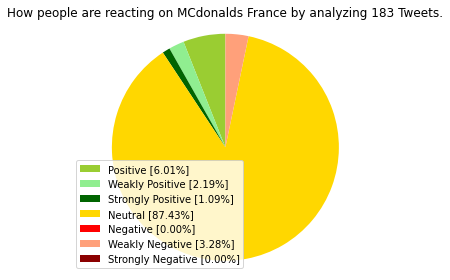

In [102]:
objet = OpinionAnalysis()
objet.DownloadData()

In [189]:
pos=df[df["pos"]>=0.1]
pos.head()

,tweet_id,text,created_at,source,tokens,neg,neu,pos,compound
5,1205500302302089216,"[ecoprogress, award, grand, bravo, tous, lauré...",2019-12-13 14:50:43,Twitter for Android,ecoprogress award grand bravo tous lauréat tou...,0.094,0.500,0.406,0.7184
6,1205496652380983301,"[ecoprogress, award, maximilien, simet, région...",2019-12-13 14:36:13,Twitter for Android,ecoprogress award maximilien simet région pari...,0.000,0.696,0.304,0.5423
8,1205492684724588544,"[ecoprogress, award, zoom, def, innov, bon, pr...",2019-12-13 14:20:27,Twitter for Android,ecoprogress award zoom def innov bon pratiqu,0.000,0.632,0.368,0.5423
9,1205492684724588544,"[ecoprogress, award, zoom, def, innov, bon, pr...",2019-12-13 14:20:27,Twitter for Android,ecoprogress award zoom def innov bon pratiqu,0.000,0.632,0.368,0.5423
10,1205479255326568449,"[award, ecoprogress, part, mcdo, récompens, ré...",2019-12-13 13:27:05,Twitter for Android,award ecoprogress part mcdo récompens référent...,0.000,0.696,0.304,0.5423


In [0]:
neg = pd.DataFrame(columns=['text',	'created_at',	'source',	'tokens',	'neg',	'neu',	'pos',	'compound'])

In [191]:
neg=df[df["neg"]>=0.1]
neg.tail()

,tweet_id,text,created_at,source,tokens,neg,neu,pos,compound
137,1147158584331046913,"[mcdofridayfact, spécial, étudi, être, adapt, ...",2019-07-05 15:01:34,Twitter Web Client,mcdofridayfact spécial étudi être adapt besoin...,0.208,0.792,0.000,-0.2732
166,1141031535845490688,"[aujourd, hui, bimbo, fournisseur, pain, ensei...",2019-06-18 17:14:52,Twitter Web Client,aujourd hui bimbo fournisseur pain enseign coo...,0.268,0.732,0.000,-0.5106
167,1140541427757309952,"[rt, zearaman, grand, nettoyag, printemp, mais...",2019-06-17 08:47:21,Twitter Web Client,rt zearaman grand nettoyag printemp maison par...,0.103,0.690,0.207,0.3612
171,1139478067032842240,"[mcdofridayfact, tout, pêcher, engagent, respe...",2019-06-14 10:21:56,Twitter Web Client,mcdofridayfact tout pêcher engagent respect ré...,0.129,0.603,0.267,0.3818
172,1138728263436648448,"[visit, sit, prépar, pain, bun, bimboqsr, mcdo...",2019-06-12 08:42:29,Twitter Web Client,visit sit prépar pain bun bimboqsr mcdo vmerog...,0.248,0.752,0.000,-0.5106


In [108]:
import plotly.graph_objects as go
labels = df['source'].unique()
values = df['source'].value_counts()
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()

# Intérprétation
-	Pour les sources des tweets, on a remarqué que la présence de Twitter Deck est de 53.6 % et pour Android et IPhone elle est de  18% combinés ce qui explique que la tranche d’âge qui mettent des tweets est celle des jeunes(entre 12 et 25 ans) et cela est tout à fait logique car c’est la tranche d’âge la plus susceptible à consommer  les fast-foods et à commander leurs repas à la maison.

# WordCloud:
-	Les word-clouds des mots en générale et des mots positifs et négatifs séparés pour connaitre les causes de leurs opinions que ce soit positifs ou négatifs  

In [0]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["tokens"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df["tokens"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([df, doc2vec_df], axis=1)


WordClous des mots positifs

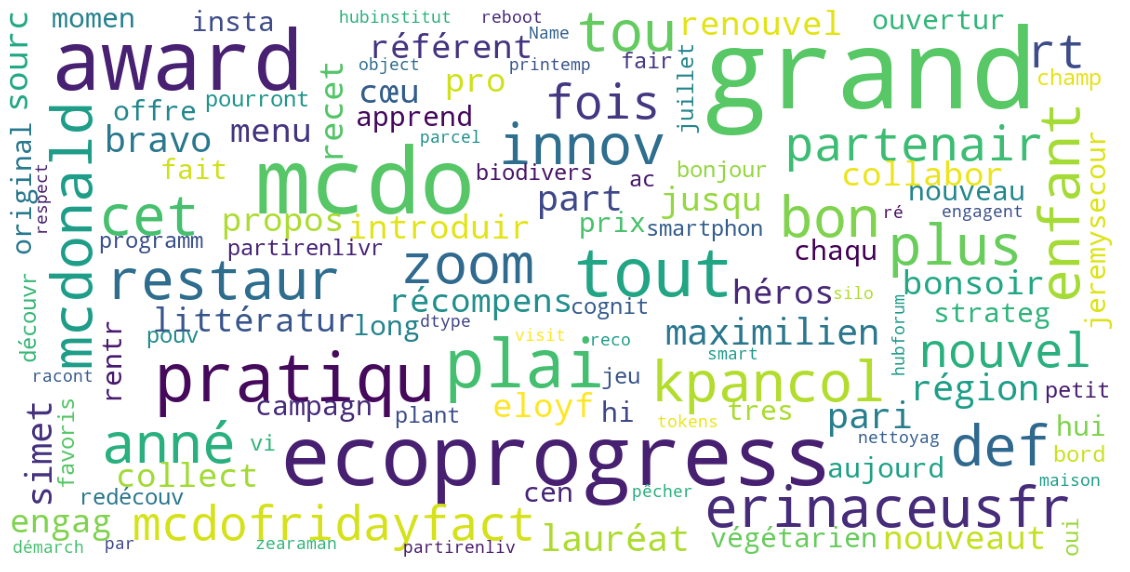

In [127]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(pos["tokens"])

WordClous des mots négatifs

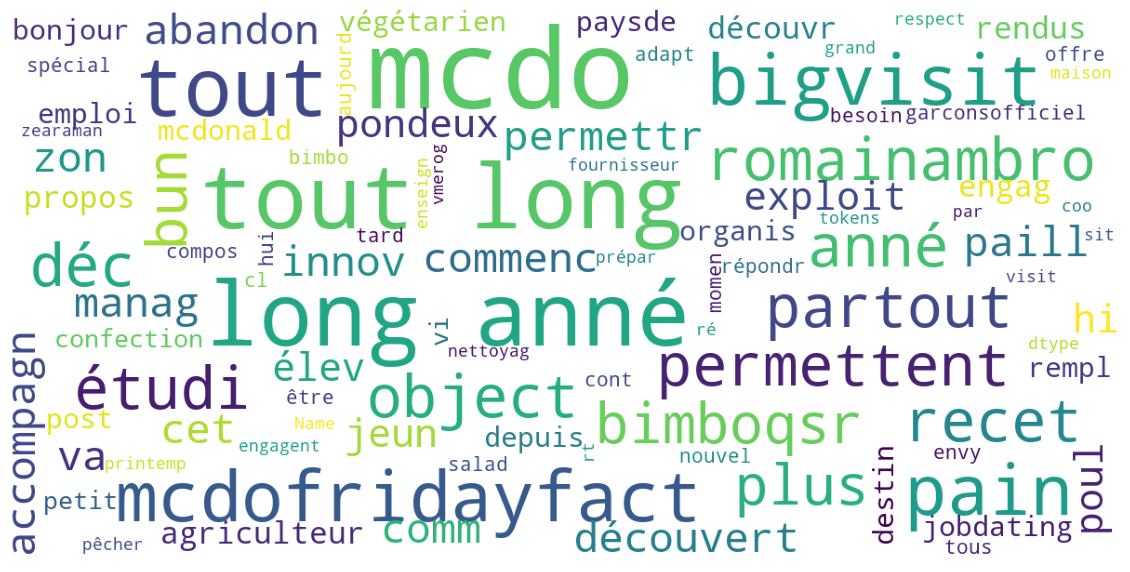

In [121]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(neg["tokens"])

WordClous de tous les mots

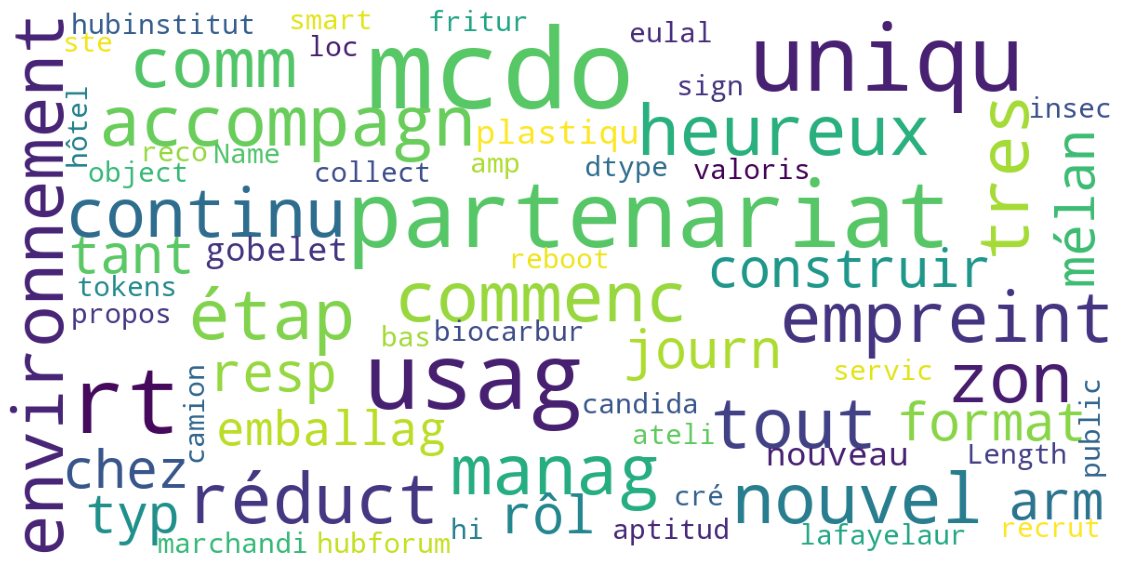

In [131]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["tokens"])

# Inteprétation : 

-	Pour les word-clouds on a pu comprendre que les gens sont plus ou moins satisfaits par les services de « MacdoFrance » surtout dans cette période de confinement et cela est expliqué par la présence des mots heureux, héros, grand, bon, award, pratique. Mais aussi il y a quelques avis négatifs et ce type de tweet contient les mots lent, pain, petit et cela est expliqué par la lenteur du service et de la livraison et le manque de personnels surtout dans cette période de confinement où le charge était immense sur « MacdoFrance » vu qu’il est le seul fast-food qui a continué de livrer sur Paris

# Les Classificateurs :

(LogisticRegression, KNeighborsClassifier, SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, GaussianNB) pour prédire l’opinion d’un tweet. Et on a va  comparer la précisions de nos modèles 

In [0]:
neu=pd.DataFrame(columns=['text',	'created_at',	'source',	'tokens',	'neg',	'neu',	'pos',	'compound'])

In [193]:
neu=df[df["neu"]>=1]
neu.head()

,tweet_id,text,created_at,source,tokens,neg,neu,pos,compound
0,1210485972514885634,"[nouvel, étap, mcdo, réduct, empreint, environ...",2019-12-27 09:02:00,TweetDeck,nouvel étap mcdo réduct empreint environnement...,0.0,1.0,0.0,0.0
2,1209060286734487552,"[tres, heureux, continu, construir, partenaria...",2019-12-23 10:36:50,Twitter Web App,tres heureux continu construir partenariat arm...,0.0,1.0,0.0,0.0
3,1207940449245134848,"[mélan, resp, format, chez, mcdo, journ, typ, ...",2019-12-20 08:27:00,TweetDeck,mélan resp format chez mcdo journ typ rôl tant...,0.0,1.0,0.0,0.0
4,1206515505655357440,"[emballag, plastiqu, usag, uniqu, nouveau, gob...",2019-12-16 10:04:47,Twitter Web App,emballag plastiqu usag uniqu nouveau gobelet c...,0.0,1.0,0.0,0.0
7,1205495672000143360,"[elis, tailhardat, région, ouest, guéret, tenu...",2019-12-13 14:32:19,Twitter for Android,elis tailhardat région ouest guéret tenu stand...,0.0,1.0,0.0,0.0


In [194]:
pos["sentiment"]="positive"
pos.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,tweet_id,text,created_at,source,tokens,neg,neu,pos,compound,sentiment
163,1141290036710858752,"[juillet, mcdo, nouvel, fois, partenair, parti...",2019-06-19 10:22:03,Twitter Web Client,juillet mcdo nouvel fois partenair partirenliv...,0.000,0.750,0.250,0.4588,positive
165,1141032012930830336,"[visit, parcel, silo, racont, cet, démarch, pr...",2019-06-18 17:16:45,Twitter Web Client,visit parcel silo racont cet démarch pratiqu a...,0.000,0.769,0.231,0.4019,positive
167,1140541427757309952,"[rt, zearaman, grand, nettoyag, printemp, mais...",2019-06-17 08:47:21,Twitter Web Client,rt zearaman grand nettoyag printemp maison par...,0.103,0.690,0.207,0.3612,positive
171,1139478067032842240,"[mcdofridayfact, tout, pêcher, engagent, respe...",2019-06-14 10:21:56,Twitter Web Client,mcdofridayfact tout pêcher engagent respect ré...,0.129,0.603,0.267,0.3818,positive
179,1136337597859602432,"[rt, hubinstitut, smart, reboot, them, hubforu...",2019-06-05 18:22:50,Twitter Web Client,rt hubinstitut smart reboot them hubforum reco...,0.000,0.803,0.197,0.4019,positive


In [195]:
neg["sentiment"]="negative"
neg.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,tweet_id,text,created_at,source,tokens,neg,neu,pos,compound,sentiment
137,1147158584331046913,"[mcdofridayfact, spécial, étudi, être, adapt, ...",2019-07-05 15:01:34,Twitter Web Client,mcdofridayfact spécial étudi être adapt besoin...,0.208,0.792,0.000,-0.2732,negative
166,1141031535845490688,"[aujourd, hui, bimbo, fournisseur, pain, ensei...",2019-06-18 17:14:52,Twitter Web Client,aujourd hui bimbo fournisseur pain enseign coo...,0.268,0.732,0.000,-0.5106,negative
167,1140541427757309952,"[rt, zearaman, grand, nettoyag, printemp, mais...",2019-06-17 08:47:21,Twitter Web Client,rt zearaman grand nettoyag printemp maison par...,0.103,0.690,0.207,0.3612,negative
171,1139478067032842240,"[mcdofridayfact, tout, pêcher, engagent, respe...",2019-06-14 10:21:56,Twitter Web Client,mcdofridayfact tout pêcher engagent respect ré...,0.129,0.603,0.267,0.3818,negative
172,1138728263436648448,"[visit, sit, prépar, pain, bun, bimboqsr, mcdo...",2019-06-12 08:42:29,Twitter Web Client,visit sit prépar pain bun bimboqsr mcdo vmerog...,0.248,0.752,0.000,-0.5106,negative


In [196]:
neu["sentiment"]="neutre"
neu.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,tweet_id,text,created_at,source,tokens,neg,neu,pos,compound,sentiment
177,1136550258832486400,"[client, jam, aut, venus, chez, déclar, nawfal...",2019-06-06 08:27:52,Twitter Web Client,client jam aut venus chez déclar nawfal trabel...,0.0,1.0,0.0,0.0,neutre
178,1136337734958796801,"[rt, lafayelaur, recrut, bas, uniqu, aptitud, ...",2019-06-05 18:23:22,Twitter Web Client,rt lafayelaur recrut bas uniqu aptitud candida...,0.0,1.0,0.0,0.0,neutre
180,1135469679764545539,"[partenariat, sign, servic, public, amp, colle...",2019-06-03 08:54:02,Twitter Web Client,partenariat sign servic public amp collect loc...,0.0,1.0,0.0,0.0,neutre
181,1135189555454365696,"[mcdo, ste, eulal, propos, hi, ateli, cré, hôt...",2019-06-02 14:20:55,Twitter for Android,mcdo ste eulal propos hi ateli cré hôtel insec...,0.0,1.0,0.0,0.0,neutre
182,1134849989107232768,"[fritur, usag, valoris, biocarbur, camion, mar...",2019-06-01 15:51:36,Twitter Web Client,fritur usag valoris biocarbur camion marchandi...,0.0,1.0,0.0,0.0,neutre


In [0]:
pos=pd.concat([pos, neg])

In [198]:
pos.tail()

,tweet_id,text,created_at,source,tokens,neg,neu,pos,compound,sentiment
137,1147158584331046913,"[mcdofridayfact, spécial, étudi, être, adapt, ...",2019-07-05 15:01:34,Twitter Web Client,mcdofridayfact spécial étudi être adapt besoin...,0.208,0.792,0.000,-0.2732,negative
166,1141031535845490688,"[aujourd, hui, bimbo, fournisseur, pain, ensei...",2019-06-18 17:14:52,Twitter Web Client,aujourd hui bimbo fournisseur pain enseign coo...,0.268,0.732,0.000,-0.5106,negative
167,1140541427757309952,"[rt, zearaman, grand, nettoyag, printemp, mais...",2019-06-17 08:47:21,Twitter Web Client,rt zearaman grand nettoyag printemp maison par...,0.103,0.690,0.207,0.3612,negative
171,1139478067032842240,"[mcdofridayfact, tout, pêcher, engagent, respe...",2019-06-14 10:21:56,Twitter Web Client,mcdofridayfact tout pêcher engagent respect ré...,0.129,0.603,0.267,0.3818,negative
172,1138728263436648448,"[visit, sit, prépar, pain, bun, bimboqsr, mcdo...",2019-06-12 08:42:29,Twitter Web Client,visit sit prépar pain bun bimboqsr mcdo vmerog...,0.248,0.752,0.000,-0.5106,negative


In [0]:
pos=pd.concat([pos, neu])

In [200]:
pos.tail()

,tweet_id,text,created_at,source,tokens,neg,neu,pos,compound,sentiment
177,1136550258832486400,"[client, jam, aut, venus, chez, déclar, nawfal...",2019-06-06 08:27:52,Twitter Web Client,client jam aut venus chez déclar nawfal trabel...,0.0,1.0,0.0,0.0,neutre
178,1136337734958796801,"[rt, lafayelaur, recrut, bas, uniqu, aptitud, ...",2019-06-05 18:23:22,Twitter Web Client,rt lafayelaur recrut bas uniqu aptitud candida...,0.0,1.0,0.0,0.0,neutre
180,1135469679764545539,"[partenariat, sign, servic, public, amp, colle...",2019-06-03 08:54:02,Twitter Web Client,partenariat sign servic public amp collect loc...,0.0,1.0,0.0,0.0,neutre
181,1135189555454365696,"[mcdo, ste, eulal, propos, hi, ateli, cré, hôt...",2019-06-02 14:20:55,Twitter for Android,mcdo ste eulal propos hi ateli cré hôtel insec...,0.0,1.0,0.0,0.0,neutre
182,1134849989107232768,"[fritur, usag, valoris, biocarbur, camion, mar...",2019-06-01 15:51:36,Twitter Web Client,fritur usag valoris biocarbur camion marchandi...,0.0,1.0,0.0,0.0,neutre


In [0]:
def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [0]:
def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

In [0]:
pos['sentiments']=pos['sentiment'].apply(lambda x: 0 if x=='negative' else 1)

In [0]:
pos['Tweet_length']=pos['tokens'].apply(lambda x: clean_tweet_length(x))

In [0]:
train,test = train_test_split(pos,test_size=0.2,random_state=42)


In [0]:
train_clean_tweet=[]
for tweet in train['tokens']:
    train_clean_tweet.append(tweet)
test_clean_tweet=[]
for tweet in test['tokens']:
    test_clean_tweet.append(tweet)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_clean_tweet)
test_features=v.transform(test_clean_tweet)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [0]:
Classifiers = [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()]

In [216]:
dense_features=train_features.toarray()
dense_test= test_features.toarray()
Accuracy=[]
Model=[]
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features,train['sentiments'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features,train['sentiments'])
        pred = fit.predict(dense_test)
    accuracy = accuracy_score(pred,test['sentiments'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))  

Accuracy of LogisticRegressionis 0.8947368421052632
Accuracy of KNeighborsClassifieris 0.8947368421052632
Accuracy of SVCis 0.8947368421052632
Accuracy of DecisionTreeClassifieris 0.9473684210526315
Accuracy of RandomForestClassifieris 0.868421052631579
Accuracy of AdaBoostClassifieris 0.9473684210526315
Accuracy of GaussianNBis 0.8421052631578947


Text(0.5, 1.0, 'Accuracies of Models')

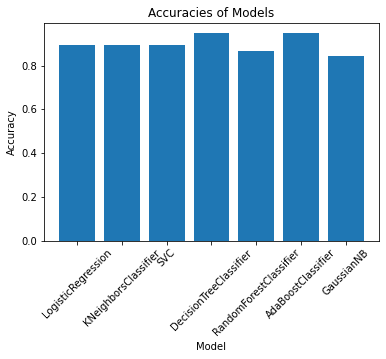

In [217]:
Index = [1,2,3,4,5,6,7]
plt.bar(Index,Accuracy)
plt.xticks(Index, Model,rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')

# Interprétation:

-	Pour les classificateurs on a atteint un bon score de précision dans presque tous le modèle mais les meilleurs modèles restent le DecisionTree et AdaBoost Classifieris avec 95% de précision.

# Interprétation générale : 
Pendant le confinement l’image de « MacdoFrance » s’est améliorée vu qu’il est le seul fast-food qui a continué à assurer ses commandes et ses livraisons ce qui lui a permis de gagner des points contre ses conccurents directes Burger King et Kfc. 
Reste à voir les avis des clients sur d’autres plateformes comme TripAdvisor ou Facebook où les utilisateurs sont plus âgées que les utilisateurs de twitter. 
